In [6]:
import numpy as np
from numba import cuda
from PIL import Image
import matplotlib.pyplot as plt

#### Kernel step 1: Convert image to gray (MAP)

In [7]:
@cuda.jit
def rgb_to_gray_kernel(rgb, gray):
    tx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    ty = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    if tx < gray.shape[1] and ty < gray.shape[0]:
        # Map formula 
        gray[ty, tx] = (
            1/3 * rgb[ty, tx, 0] +  # Red
            1/3 * rgb[ty, tx, 1] +  # Green
            1/3 * rgb[ty, tx, 2]    # Blue
        )

#### Kernel step 2: Find min/max intensity of image (REDUCE)

In [8]:
@cuda.jit
def find_min_max_kernel(gray, min_max):
    # Thread identification
    localtid = cuda.threadIdx.x #in cache/shared memory
    tid = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Shared memory declaration for caching block content
    cache_min = cuda.shared.array((256,), dtype=np.float32)
    cache_max = cuda.shared.array((256,), dtype=np.float32)
    
    # Initialize shared memory
    if tid < gray.size:
        # Finding corresponding pixel to thread ID
        row = tid // gray.shape[1]
        col = tid % gray.shape[1]
        pixel_value = gray[row, col]
        # Put the pixel value in shared memory
        cache_min[localtid] = pixel_value
        cache_max[localtid] = pixel_value
    else:
        cache_min[localtid] = np.float32(255)  # Avoid from min with assigned max possible value
        cache_max[localtid] = np.float32(0)    # Avoid from max with assigned min possible value
    
    cuda.syncthreads()
    
    # Reduction in cache (both min and max)
    s = cuda.blockDim.x // 2 #stride
    while s > 0:
        if localtid < s:
            cache_min[localtid] = min(cache_min[localtid], cache_min[localtid + s])
            cache_max[localtid] = max(cache_max[localtid], cache_max[localtid + s])
        cuda.syncthreads()
        s = s // 2
    
    # Only first thread writes back to global memory
    if localtid == 0:
        min_max[cuda.blockIdx.x, 0] = cache_min[0]
        min_max[cuda.blockIdx.x, 1] = cache_max[0]

#### Kernel step 3: Linearly recalculate intensity for each pixel (MAP)

In [9]:
@cuda.jit
def stretch_kernel(gray, min_max):
    tx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    ty = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    if tx < gray.shape[1] and ty < gray.shape[0]:
        # Stretch formula: (pixel - min) * 255 / (max - min)
        # Reverse for [row, column] in image
        pixel = gray[ty, tx]
        min_val = min_max[0]
        max_val = min_max[1]
        
        if max_val > min_val:  # Prevent division by zero
            gray[ty, tx] = (pixel - min_val) * 255 / (max_val - min_val)

#### Processing

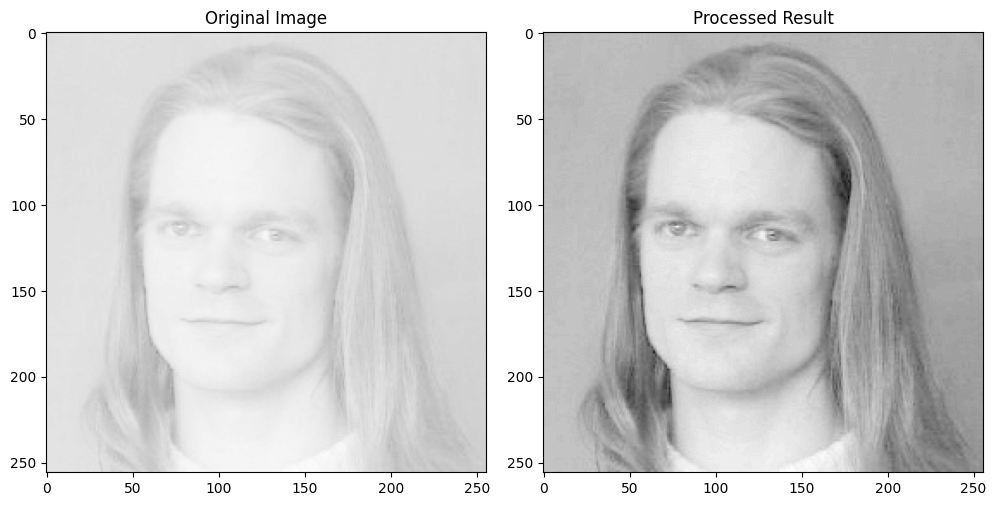

In [10]:
def grayscale_stretch(image):
    height, width = image.shape[0], image.shape[1]
    
    # Set up block and grid 
    BLOCK_DIM = (16, 16)
    grid_dim = (
        (width + BLOCK_DIM[0] - 1) // BLOCK_DIM[0],
        (height + BLOCK_DIM[1] - 1) // BLOCK_DIM[1]
    )
    
    # Step 1: Convert to grayscale
    d_rgb = cuda.to_device(image)
    gray_img = np.zeros((height, width), dtype=np.float32)
    d_gray = cuda.to_device(gray_img)
    rgb_to_gray_kernel[grid_dim, BLOCK_DIM](d_rgb, d_gray)
    
    # Step 2: Find min and max values
    reduce_block_size = 256
    reduce_grid_size = (gray_img.size + reduce_block_size - 1) // reduce_block_size
    min_max = np.zeros((reduce_grid_size, 2), dtype=np.float32)
    d_min_max = cuda.to_device(min_max)
    find_min_max_kernel[reduce_grid_size, reduce_block_size](d_gray, d_min_max)
    
    # Get results back and find global min/max
    min_max = d_min_max.copy_to_host()
    global_min = np.min(min_max[:, 0])  # Find minimum across all blocks
    global_max = np.max(min_max[:, 1])  # Find maximum across all blocks
    
    # Copy min/max values to CPU
    min_max_final = np.array([global_min, global_max], dtype=np.float32)
    d_min_max_final = cuda.to_device(min_max_final)
    
    # Step 3: Stretch the intensity values
    stretch_kernel[grid_dim, BLOCK_DIM](d_gray, d_min_max_final)
    
    # GPU copy result to CPU
    result = d_gray.copy_to_host()
    return result

# Usage example
if __name__ == "__main__":
    image = plt.imread("image2.png")
    if image.dtype == np.uint8:
        image = image.astype(np.float32) / 255.0
    
    result = grayscale_stretch(image)
    # Display results
    plt.figure(figsize=(15, 5))
    
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

plt.subplot(132)
plt.imshow(result, cmap='gray')
plt.title("Processed Result")

plt.tight_layout()
plt.show()